# Visualisation of data for Prestweets


## Imports

In [46]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alibor/nltk_data...


True

In [44]:
import json
import pandas as pd
import os
from textblob import TextBlob
import nltk
import tweepy
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers 
from nltk.sentiment import SentimentIntensityAnalyzer

## Preparation of a joint dataframe for all 5 politicians with objectivity and polarity

In [2]:
print(os.getcwd())

/home/alibor/code/reichardtma/prestweets/notebooks


In [3]:
boris = pd.read_csv('borisjohnson_tweets.csv')
jokowi = pd.read_csv('jokowi_tweets.csv')
jokowi['content'] = jokowi['Translation']
jokowi = jokowi.drop(columns= ['Translation'])
jb = pd.read_csv('jairbolsonaro_tweets.csv')
jb['content'] = jb['Translation']
jb = jb.drop(columns= ['Translation'])
macron = pd.read_csv('EmmanuelMacron_tweets.csv')
macron['content'] = macron['Translation']
macron = macron.drop(columns= ['Translation'])
cr = pd.read_csv('CyrilRamaphosa_tweets.csv')

In [4]:
presis = [boris,jokowi,jb,macron,cr]
presis_name = ['boris','jokowi','jb','macron','cr']
for i in range(5):
    presis[i]['Unnamed: 0'] = presis_name[i]

In [5]:
pres = pd.concat([boris,jokowi,jb,macron,cr], axis=0)

In [6]:
pres = pres.rename(columns={"Unnamed: 0": "name"})

In [7]:
def remove_punctuation(text):
    text = ''.join([i for i in text if i not in string.punctuation])
    return text
def lower_case(text):
    text = text.lower()
    return text
def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = ''.join(lemmatizer.lemmatize(word) for word in text)
    return text
def stop_words(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    text = ' '.join(w for w in word_tokens if not w in stop_words)
    return text

pres = pres[pres.content.map(lambda x: isinstance(x,str))]
    
pres['clean_translation'] = pres['content'].apply(lemmatize).\
apply(lower_case).apply(remove_numbers).apply(remove_punctuation).apply(stop_words)

In [ ]:
def polarity(s):
    pol = TextBlob(s)
    pol = pol.sentiment[0]
    return pol

def objectivity(s):
    obj = TextBlob(s)
    obj = obj.sentiment[1]
    return obj

pres['polarity'] = pres['clean_translation'].apply(polarity)
pres['objectivity'] = pres['clean_translation'].apply(objectivity)

In [10]:
pres['date'] = pd.to_datetime(pres['date']).dt.date

In [11]:
pres = pres.sort_values("date")

In [12]:
pres = pres.reset_index()
pres = pres.drop(columns = ['index'])

In [13]:
pres.head(3)

name           id                                                url  \
0   jb  11398556610  https://twitter.com/jairbolsonaro/status/11398...   
1   jb  11406381330  https://twitter.com/jairbolsonaro/status/11406...   
2   jb  11405864533  https://twitter.com/jairbolsonaro/status/11405...   

         date                                            content hashtags  \
0  2010-04-01  Good night everyone @depchicolanecar @reporter...      NaN   
1  2010-04-01  debate64# O Globo cover editorial of 07/Oct/84...      NaN   
2  2010-04-01  debate64#What are you complaining about? They'...      NaN   

   cashtags media lang                                  clean_translation  \
0       NaN   NaN   pt  good night everyone depchicolanecar reportercrime   
1       NaN   NaN   pt  debate globo cover editorial oct judgment revo...   
2       NaN   NaN   pt  debatewhat complaining theyve voting years sti...   

   polarity  objectivity  
0       0.7          0.6  
1      -0.6          0.9  
2       0.0          0.0

## Preparation of a new dataframe for the coming plots (tweets per day per politician)

In [14]:
pres_per_day = pres.groupby(['date','name'])['content'].count()

In [15]:
pres_per_day = pres_per_day.reset_index()

In [16]:
pres_per_day = pres_per_day.rename(columns={"content": "num_tweets"})

## Plot of the number of tweets per day per politician

In [17]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(data=pres_per_day, x = pres_per_day.date, y = pres_per_day.num_tweets, 
             hue= pres_per_day.name, palette="tab10", linewidth=2.5)
plt.xticks([pres_per_day.date.min(),pres_per_day.date[len(pres_per_day.date)//3], 
            pres_per_day.date[len(pres_per_day.date)//2], pres_per_day.date.max()], 
           [f'{pres_per_day.date.min()}', f'{pres_per_day.date[len(pres_per_day.date)//3]}',
            f'{pres_per_day.date[len(pres_per_day.date)//2]}',f'{pres_per_day.date.max()}'])
plt.show()

## Preparation of a new dataframe for the coming plots

In [18]:
pres_obj_pol = pres.groupby(['date', 'name'], as_index=False).mean()

In [19]:
pres_obj_pol['num_tweets'] = pres.groupby(['date','name'], as_index=False)['content'].count()['content']

In [20]:
pres_obj_pol['date'] = pres_obj_pol['date'].apply(lambda x: x.strftime('%B-%Y'))
pres_obj_pol = pres_obj_pol.groupby(['date', 'name'], as_index=False).mean()

In [21]:
pres_obj_pol.head(3)

date name            id  cashtags  polarity  objectivity  num_tweets
0  April-2010   jb  1.214037e+10       NaN -0.011951     0.200862   15.000000
1  April-2013   jb  3.227765e+17       NaN -0.026261     0.252527    2.125000
2  April-2014   jb  4.561191e+17       NaN  0.009921     0.093254    1.611111

## Plot of mean objectivity per month per politician

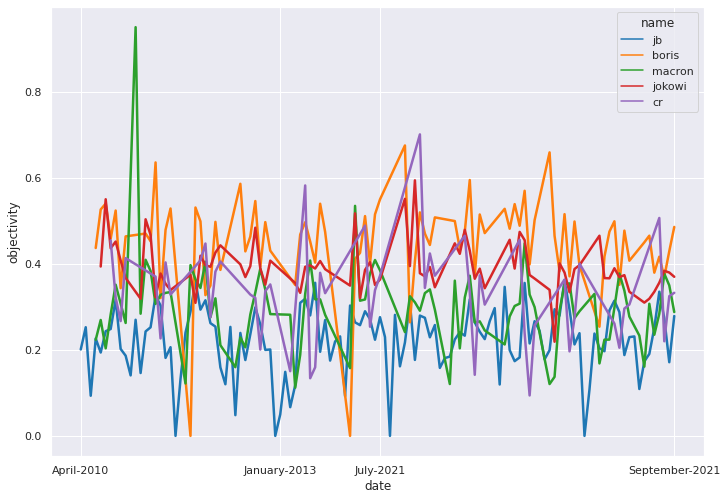

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=pres_obj_pol, x = pres_obj_pol.date, y = pres_obj_pol.objectivity, 
             hue= pres_obj_pol.name, palette="tab10", linewidth=2.5)
plt.xticks([pres_obj_pol.date.min(),pres_obj_pol.date[len(pres_obj_pol.date)//3],
            pres_obj_pol.date[len(pres_obj_pol.date)//2], pres_obj_pol.date.max()],
           [f'{pres_obj_pol.date.min()}', f'{pres_obj_pol.date[len(pres_obj_pol.date)//3]}',
            f'{pres_obj_pol.date[len(pres_obj_pol.date)//2]}',f'{pres_obj_pol.date.max()}'])
plt.show()

## Plot of mean polarity per month per politician

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=pres_obj_pol, x = pres_obj_pol.date, y = pres_obj_pol.polarity, 
             hue= pres_obj_pol.name, palette="tab10", linewidth=2.5)
plt.xticks([pres_obj_pol.date.min(),pres_obj_pol.date[len(pres_obj_pol.date)//3],
            pres_obj_pol.date[len(pres_obj_pol.date)//2], pres_obj_pol.date.max()],
           [f'{pres_obj_pol.date.min()}', f'{pres_obj_pol.date[len(pres_obj_pol.date)//3]}',
            f'{pres_obj_pol.date[len(pres_obj_pol.date)//2]}',f'{pres_obj_pol.date.max()}'])
plt.show()

## Plot of mean of polarity multiplied by objectivity per month per politician

In [24]:
highlight_macron = pres_obj_pol.loc[(pres_obj_pol['name'] == 'macron') & 
                                    (pres_obj_pol['objectivity'] == pres_obj_pol['objectivity'].max()),['date']]

In [25]:
highlight_macron['date'][36]

'August-2014'

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=pres_obj_pol, x = pres_obj_pol.date, y = (abs(pres_obj_pol.polarity)*pres_obj_pol.objectivity), 
             hue= pres_obj_pol.name, palette="tab10", linewidth=2.5)
plt.xticks([pres_obj_pol.date.min(), highlight_macron['date'][36],
            pres_obj_pol.date[len(pres_obj_pol.date)//3],
            pres_obj_pol.date[len(pres_obj_pol.date)//2], pres_obj_pol.date.max()], 
           [f'{pres_obj_pol.date.min()}', f'{highlight_macron["date"][36]}',
            f'{pres_obj_pol.date[len(pres_obj_pol.date)//3]}',
            f'{pres_obj_pol.date[len(pres_obj_pol.date)//2]}',f'{pres_obj_pol.date.max()}'])
plt.show()

## Trying TextCNN with CountVectorizer - not successful || NLTKÂ´s polarity analysis

<div class="alert alert-block alert-info">
*Question: shall we split the data to train/test sets?*
</div>

In [30]:
vectorizer = CountVectorizer()
vectorized = vectorizer.fit(pres.clean_translation)
print(f"Size of the vocab: {len(vectorizer.vocabulary_)}")

Size of the vocab: 59732


In [69]:
def sia_pol(tweet):
    sia = SentimentIntensityAnalyzer()
    polarity = [sia.polarity_scores(tweet)['neg'], sia.polarity_scores(tweet)['neu'],
                                sia.polarity_scores(tweet)['pos']]
    return polarity.index(max(polarity))

pres['sia_pol'] = pres['clean_translation'].apply(sia_pol)

In [70]:
def pol_score(tweet):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(tweet)['compound']

pres['pol_score'] = pres['clean_translation'].apply(pol_score)

In [71]:
pres.sia_pol.describe()

count    39241.000000
mean         1.049056
std          0.300550
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: sia_pol, dtype: float64

In [72]:
pres.pol_score.describe()

count    39241.000000
mean         0.240081
std          0.461676
min         -0.981400
25%          0.000000
50%          0.273200
75%          0.636900
max          0.988500
Name: pol_score, dtype: float64

In [74]:
def decoder(index):
    if index == 0:
        index = 'neg'
    elif index == 1:
        index = 'neu'
    else:
        index = 'pos'
    return index
pres['sia_pol'] = pres['sia_pol'].apply(decoder)

In [85]:
pres = pres.drop(columns=['sia_polarity'])

In [86]:
pres.head()

name           id                                                url  \
0   jb  11398556610  https://twitter.com/jairbolsonaro/status/11398...   
1   jb  11406381330  https://twitter.com/jairbolsonaro/status/11406...   
2   jb  11405864533  https://twitter.com/jairbolsonaro/status/11405...   
3   jb  11405639111  https://twitter.com/jairbolsonaro/status/11405...   
4   jb  11405331822  https://twitter.com/jairbolsonaro/status/11405...   

         date                                            content hashtags  \
0  2010-04-01  Good night everyone @depchicolanecar @reporter...      NaN   
1  2010-04-01  debate64# O Globo cover editorial of 07/Oct/84...      NaN   
2  2010-04-01  debate64#What are you complaining about? They'...      NaN   
3  2010-04-01  debate64#I lost track, I'll send you all know ...      NaN   
4  2010-04-01  debate64#I'm sorry I tortured you, I know the ...      NaN   

   cashtags media lang                                  clean_translation  \
0       NaN   NaN   pt  good night everyone depchicolanecar reportercrime   
1       NaN   NaN   pt  debate globo cover editorial oct judgment revo...   
2       NaN   NaN   pt  debatewhat complaining theyve voting years sti...   
3       NaN   NaN   pt           debatei lost track ill send know library   
4       NaN   NaN   pt           debateim sorry tortured know truth hurts   

   polarity  objectivity sia_pol  pol_score  
0       0.7          0.6     neu     0.4404  
1      -0.6          0.9     neu     0.3182  
2       0.0          0.0     neu    -0.2023  
3      -0.5          1.0     neg    -0.6249  
4      -0.5          1.0     neg    -0.6908

## Checking the correlation between NLTK polarity and TextBlob polarity

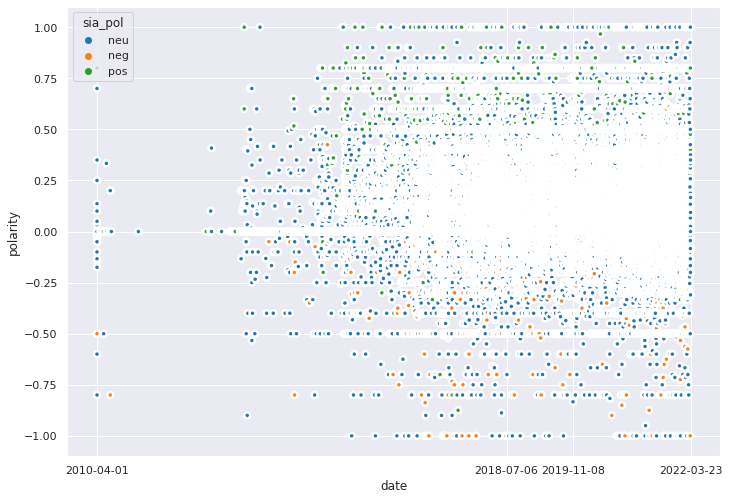

In [90]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=pres, x = pres.date, y = pres.polarity, 
             hue= pres.sia_pol, palette="tab10", linewidth=2.5)
plt.xticks([pres.date.min(),pres.date[len(pres.date)//3],
            pres.date[len(pres.date)//2], pres.date.max()],
           [f'{pres.date.min()}', f'{pres.date[len(pres.date)//3]}',
            f'{pres.date[len(pres.date)//2]}',f'{pres.date.max()}'])
plt.show()